# LeNet-5 Fashion MNIST Classifier using PyTorch

## Description

The aim of this project was to develop a deep learning image classifier capable of accurately classifying images from the Fashion MNIST dataset. Fashion MNIST is a dataset containing 50,000 grayscale images of clothing items belonging to 10 different categories, with 5,000 images per category. The classifier was built using PyTorch, a popular deep learning framework, and employed LeNet-5 the convolutional neural network architecture to demonstrate its simplicity but also its effectiveness in computationally intense image classification tasks.

## Code

### Imports

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import re
from PIL import Image, ImageFile
import torch
import torch.utils.data as data
import torchvision
from torch import optim, nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [68]:
# Utilizing CUDA cores if possible to speed up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [69]:
training_loader = 0
validation_loader = 0
neural_network = 0

### Getting the Data

In [70]:
global training_loader
global validation_loader
training_data = datasets.ImageFolder('training_set', transform = transforms.ToTensor())
training_set, validation_set = data.random_split(training_data, [40320, 10080])
training_loader = DataLoader(training_set, batch_size = 32, shuffle = True)
validation_loader = DataLoader(validation_set, batch_size = 32, shuffle = True)

### Image Samples

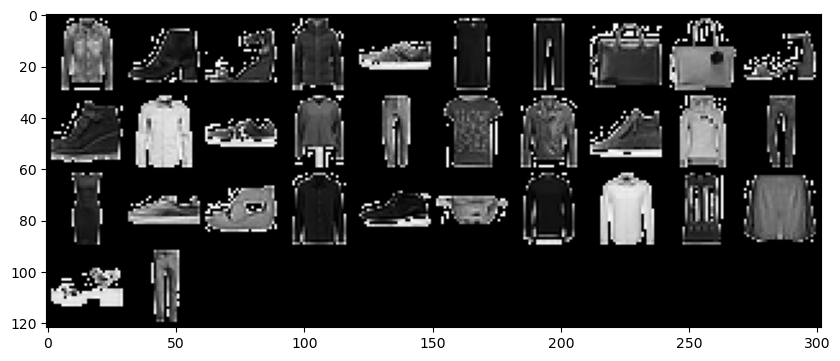

In [71]:
samples = next(iter(training_loader))
imgs = samples[0]
lbls = samples[1]
plt.figure(figsize=(10,10))
grid = torchvision.utils.make_grid(tensor=imgs, nrow=10)
grid = np.clip(grid,0,1)
plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");

### LeNet-5 Model

In [72]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

For training, the neural network uses a learning rate of 0.001, which is most optimal with the Adam optimizer. It also uses Cross Entropy Loss as it is the most powerful loss function for multi-class problems.

In [76]:
global neural_network
neural_network = CNN().to(device)
optimizer = optim.Adam(neural_network.parameters(), lr = 0.001) 
neural_network.train()
epochs = 10
loss_arr = []
accuracy_arr = []


for i in range(epochs): 
    current_loss = 0
    current_accuracy = 0
    for index, (images , labels) in enumerate(training_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        out = neural_network(images) 
        loss = nn.CrossEntropyLoss()(out, labels)
        loss.backward() 
        optimizer.step()
        current_loss += loss.item()
        pred = torch.argmax(out, dim=1)
        correct = pred.eq(labels)
        current_accuracy +=  torch.mean(correct.float()).item()

    else:
        curr_epoch = i + 1
        print("Epoch: ", curr_epoch, "/", epochs)
        print("Training loss: ", current_loss/len(training_loader))
        print("Training accuracy: ", current_accuracy/len(training_loader))
        loss_arr.append(current_loss)
        accuracy_arr.append(current_accuracy)

Epoch:  1 / 10
Training loss:  0.7177005082841903
Training accuracy:  0.7358134920634921
Epoch:  2 / 10
Training loss:  0.441536311757943
Training accuracy:  0.8413690476190476
Epoch:  3 / 10
Training loss:  0.36114863549610454
Training accuracy:  0.8684027777777777
Epoch:  4 / 10
Training loss:  0.3192611777474956
Training accuracy:  0.8811011904761905
Epoch:  5 / 10
Training loss:  0.28458592523007636
Training accuracy:  0.895188492063492
Epoch:  6 / 10
Training loss:  0.2632579660131818
Training accuracy:  0.9014136904761905
Epoch:  7 / 10
Training loss:  0.24643524419516324
Training accuracy:  0.9080357142857143
Epoch:  8 / 10
Training loss:  0.22798066150456195
Training accuracy:  0.916592261904762
Epoch:  9 / 10
Training loss:  0.21289799232183704
Training accuracy:  0.9210565476190476
Epoch:  10 / 10
Training loss:  0.19909285472572913
Training accuracy:  0.9256200396825397


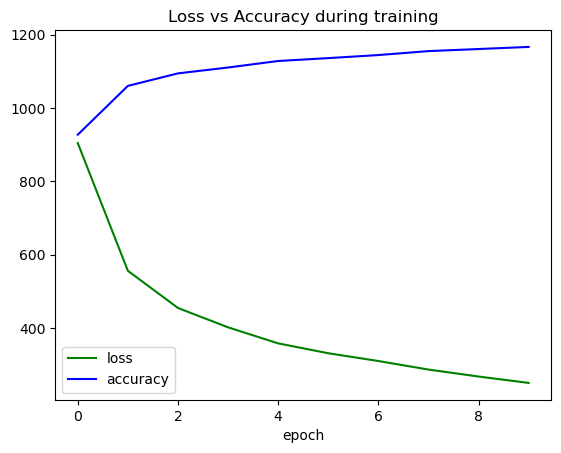

In [77]:
fig, ax1 = plt.subplots()
ax1.plot(loss_arr, label='loss', color = 'g')
ax1.plot(accuracy_arr, label='accuracy', color = 'b')
ax1.set_xlabel('epoch')
plt.legend() 
plt.title('Loss vs Accuracy during training')
plt.show()

### Evaluation

In [78]:
neural_network.eval()
with torch.no_grad():
    correct = 0
    valid_loss = 0
    all_labels = []
    all_predictions = []
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        predicted = neural_network(images)
        valid_loss += nn.CrossEntropyLoss()(predicted, labels).item()
        correct += (predicted.argmax(1) == labels).type(torch.float).sum().item()
        all_labels.extend(labels.detach().cpu().numpy())
        all_predictions.extend(predicted.argmax(1).detach().cpu().numpy())

    
    print(classification_report(all_labels, all_predictions))
    
    print(f'Accuracy on validation set: {(correct/len(validation_loader.dataset))*100:.2f}%')
    

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1124
           1       0.99      0.98      0.99      1169
           2       0.88      0.68      0.77       776
           3       0.86      0.94      0.90      1158
           4       0.78      0.88      0.83      1019
           5       0.98      0.95      0.96      1203
           6       0.68      0.67      0.68       836
           7       0.89      0.98      0.93       948
           8       0.97      0.98      0.98      1230
           9       0.98      0.89      0.93       617

    accuracy                           0.89     10080
   macro avg       0.89      0.88      0.88     10080
weighted avg       0.89      0.89      0.89     10080

Accuracy on validation set: 89.05%


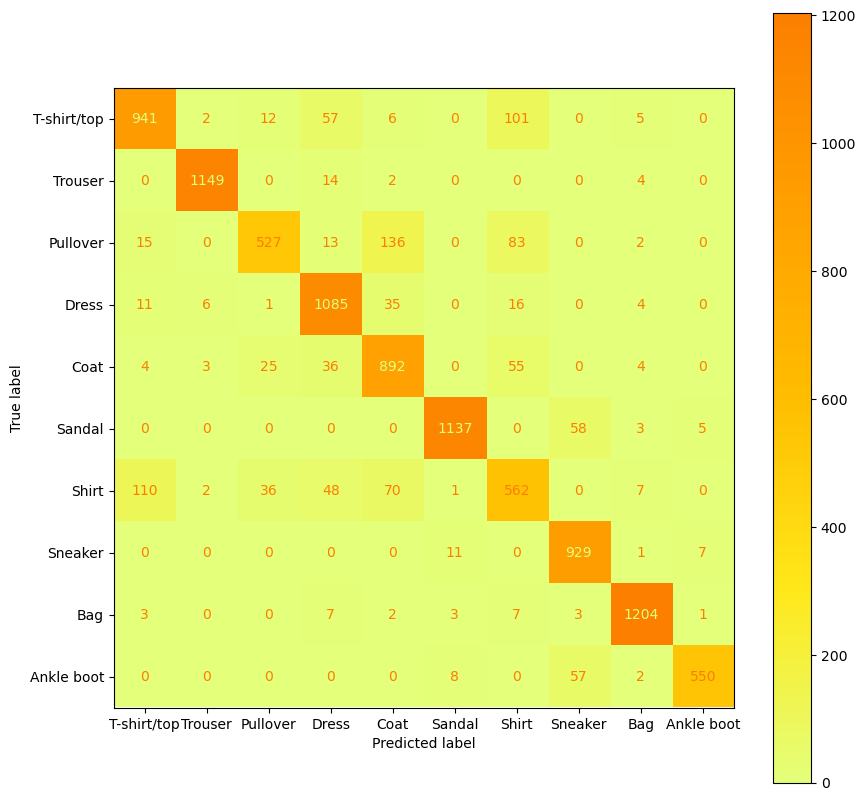

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
mat = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_labels, all_predictions), display_labels=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal" , "Shirt", "Sneaker", "Bag", "Ankle boot"] ) 
mat = mat.plot(ax=ax,cmap='Wistia')
plt.show()

### Reflection

In [12]:
with torch.no_grad():
    with open("prediction.txt",'w') as f:
        pass
        for i in sorted(os.listdir('testing_set'), key = len):
            picture = os.path.join('testing_set', i)
            temp = Image.open(picture).convert('RGB')
            transform = transforms.Compose([transforms.ToTensor()])
            temp = transform(temp)
            temp = temp.to(device)
            temp = temp.unsqueeze(0)
            output = neural_network(temp)
            _, predicted = torch.max(output.data, 1)
            predicted = predicted.cpu()
            predicted = predicted.numpy()
            f.write(str(predicted[0]))
            f.write('\n')